#HAR_model_eval_defined_subj.ipynb
Uses the defined subject list from model_eval paper to separate the data into train, validation, test sets.

Started with HAR_model_eval_stratification.ipynb



#Imports

In [ ]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
#from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from keras.utils import to_categorical # for one-hot encoding
import matplotlib.pyplot as plt # for plotting training curves
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
# to measure and display training time
import time
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import shutil #for file manipulation
import random #to remove random sampling and create validation group
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import load
from pandas import read_csv
from matplotlib import pyplot
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from keras.utils import to_categorical

# to measure and display training time
import time
from datetime import timedelta

import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib

#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [ ]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    return my_name
#start output file with unique name - important for colab runs
def start_logfiles(base_name = "unnamed", first_line = "nothing here"):
    """creates file and writes colab environment info, returns full filename
    which is concatenation of path, base_name, and current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [ ]:
DATASET = "MobiAct"


In [ ]:
DATASET = "UniMiB"

#Load the X, y, sub numpy arrays, drop component accel, one-hot encode y


In [ ]:
if (DATASET == "MobiAct"):
    input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s'
    ACT = ['JOG','JUM','STD','STN','STU','WAL']
    kernel_size = 20 # kernel is 1 second wide at 20Hz
    split_subj = {'train_subj':[2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,
                                36,38,42,45,46,47,48,49,50,51,52,53,54,57],
                   'validation_subj':[3,6,8,11,12,22,37,40,43,56],
                   'test_subj':[7,19,21,25,29,33,39,41,44,55]}
elif (DATASET == "UniMiB"):
    input_dir = '/content/drive/MyDrive/Processed_Datasets/unimib_xys'
    ACT = ['A1','A2','A3','A4','A5','A6','A7','A8'] #need to check import str
    kernel_size = 50 # kernel is 1 second wide at 50Hz
    split_subj = {'train_subj':[4,5,6,7,8,10,11,12,14,15,19,20,21,22,24,26,27,29],
              'validation_subj':[1,9,16,23,25,28],
              'test_subj':[2,3,13,17,18,30]}
else:
    print ("Unknown or undefined DATASET")
    sys.exit("Unknown or undefined DATASET")

log_info = 'arrays loaded from'
log_info += input_dir + '\n'
X = np.load(input_dir + '/' + 'X.npy')
y = np.load(input_dir + '/' +'y.npy')
sub= np.load(input_dir + '/' +'sub.npy')
shapes = get_shapes([X,y,sub])
print ("Starting shape of loaded files")
print(shapes)

# Drop component acceleration
log_xyz = "Using total component accel, deleting accel_x/y/z from X\n"
X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
log_info += log_xyz
print(get_shapes([X,y,sub]))

#One-Hot-Encode y...there must be a better way when starting with strings
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

if (y.shape[1]==1):
    # integer encode
    y_vector = np.ravel(y) #encoder won't take column vector
    le = LabelEncoder()
    integer_encoded = le.fit_transform(y_vector) #convert from string to int
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("One-hot-encoding: category names -> int -> one-hot")
    print(name_mapping)
    ACT = list(name_mapping) # keep activity names for conf matrix labels
    log_info += "One Hot:" + str(name_mapping) +"\n"
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One-hot-encoding",onehot_encoder.categories_)
    y=onehot_encoded
else:
    print ("y.shape[1] is not one, appears to be encoded already. Skipping")

print("\n",get_shapes([X,y,sub]))

Starting shape of loaded files
X shape is (13792, 60, 4) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64

X shape is (13792, 60, 1) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64

One-hot-encoding: category names -> int -> one-hot
{'JOG': 0, 'JUM': 1, 'STD': 2, 'STN': 3, 'STU': 4, 'WAL': 5}
One-hot-encoding [array([0, 1, 2, 3, 4, 5])]

 X shape is (13792, 60, 1) data type is float64
y shape is (13792, 6) data type is float64
sub shape is (13792, 1) data type is int64



#Split into pre-selected subjects 

In [ ]:
#split by pre-selected subjects (original load data grouping)
method = "manual split using pre-selected subjects\n"
log_info += "Split: " + method

train_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['train_subj']:
    print(my_sub, end =" ")
    #print(np.argwhere(sub == my_sub)[:,0])
    train_index = np.concatenate((train_index, np.argwhere(sub == my_sub)[:,0]))

validation_index = np.empty([1],dtype=int) #empty list
print("\nValidation Group adding subjects:", end =" ")
for my_sub in split_subj['validation_subj']:
    print(my_sub, end =" ")
    validation_index = np.concatenate((validation_index, np.argwhere(sub == my_sub)[:,0]))

test_index = np.empty([1],dtype=int) #empty list
print("\nTrain Group adding subjects:", end =" ")
for my_sub in split_subj['test_subj']:
    print(my_sub, end =" ")
    test_index = np.concatenate((test_index, np.argwhere(sub == my_sub)[:,0]))

print("\n")
#delete first row placeholders
train_index = np.delete(train_index, (0), axis=0) 
validation_index = np.delete(validation_index, (0), axis=0) 
test_index = np.delete(test_index, (0), axis=0)

X_train, X_test, X_validation = X[train_index], X[test_index], X[validation_index]
y_train, y_test, y_validation = y[train_index], y[test_index], y[validation_index]
new_shapes = get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test])
print (new_shapes)
log_info = log_file + new_shapes


Train Group adding subjects: 2 4 5 9 10 16 18 20 23 24 26 27 28 32 34 35 36 38 42 45 46 47 48 49 50 51 52 53 54 57 
Validation Group adding subjects: 3 6 8 11 12 22 37 40 43 56 
Train Group adding subjects: 7 19 21 25 29 33 39 41 44 55 

X_train shape is (8274, 60, 1) data type is float64
y_train shape is (8274, 6) data type is float64
X_validation shape is (2758, 60, 1) data type is float64
y_validation shape is (2758, 6) data type is float64
X_test shape is (2760, 60, 1) data type is float64
y_test shape is (2760, 6) data type is float64



# Function: evaluate_model builds and train Keras 1D CNN model

In [ ]:
#def evaluate_model(trainX, trainy, validateX, validatey, testX, testy):
#different topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
def evaluate_model(trainX, trainy, validationX, validationy, 
                    BATCH_SIZE=16, NUM_EPOCHS=200,
                    my_filters = 50, my_kernel_size = 20):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        keras.Input(shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    start_time = time.time()
    history = model.fit(
        trainX,trainy,
        steps_per_epoch=trainX.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 0, #0 = silent, 1 = progress bar, 2 = one line per epoch.
        validation_data=(validationX,validationy),
        validation_steps=validationX.shape[1]//BATCH_SIZE)
    end_time = time.time()
    train_time = timedelta(seconds=(end_time - start_time))
    print('Training time =',(np.str(train_time).split(".")[0]), 'HH:MM:SS')
    model.save('my_1D_CNN_model')
    return history

#Function: run_model predicts using the test dataset

In [ ]:
def run_model(testX, testy):
#this version broken with UniMiB
#if(False):
    model = keras.models.load_model('my_1D_CNN_model')
    start_time = time.time()
    predictions = model.predict(testX, verbose=0,batch_size=32)
    end_time = time.time()
    eval_time = timedelta(seconds=(end_time - start_time))
    print('Eval time =',(np.str(eval_time).split(".")[0]), 'HH:MM:SS')

    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test = np.argmax(testy, axis=-1)

    print(classification_report(y_test, y_pred, target_names=ACT))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    return (accuracy_score(y_test, y_pred)),y_pred, y_test

In [ ]:
#copied from stratification - one above gives error on UniMiB
def run_model(testX, testy):
    model = keras.models.load_model('my_1D_CNN_model')
    predictions = model.predict(testX, verbose=0,batch_size=32)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test = np.argmax(testy, axis=-1)
    return (accuracy_score(y_test, y_pred)),y_pred, y_test

#Loop using repeat value

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/MobiAct_Def_Sub_Apr-04-2021_1556.txt
--- batch_size = 32 kernel_size = 20 num_epochs = 200

Pass number  1  of  10
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_41 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense

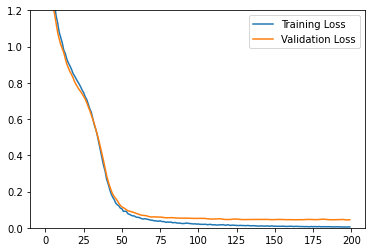

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  2  of  10
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_42 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 100)               55100     
_________________________________

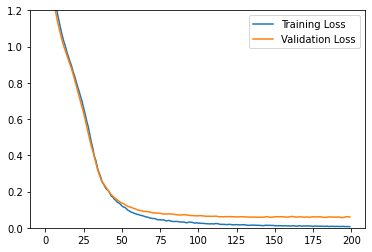

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.963
Pass number  3  of  10
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_86 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_43 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 100)               55100     
_________________________________

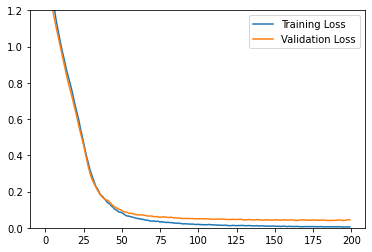

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.973
Pass number  4  of  10
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_44 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               55100     
_________________________________

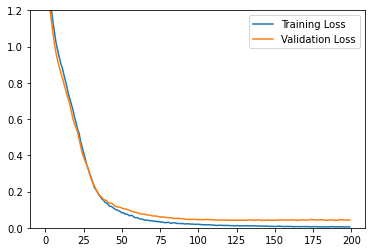

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.973
Pass number  5  of  10
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_45 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               55100     
_________________________________

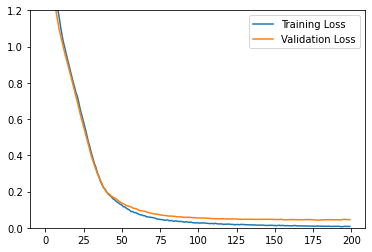

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.973
Pass number  6  of  10
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_92 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_46 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 100)               55100     
_________________________________

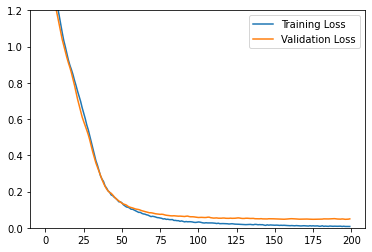

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.969
Pass number  7  of  10
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_47 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 100)               55100     
_________________________________

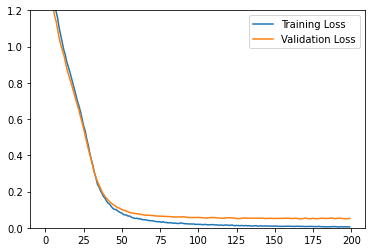

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.967
Pass number  8  of  10
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_48 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 100)               55100     
_________________________________

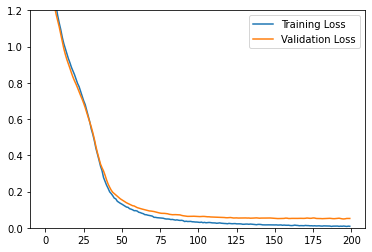

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.963
Pass number  9  of  10
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 41, 50)            1050      
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 22, 50)            50050     
_________________________________________________________________
dropout_49 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 100)               55100     
_________________________________

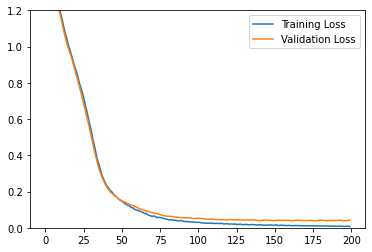

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.966
Pass number  10  of  10
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 41, 50)            1050      
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 22, 50)            50050     
_________________________________________________________________
dropout_50 (Dropout)         (None, 22, 50)            0         
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 11, 50)            0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 550)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 100)               55100     
________________________________

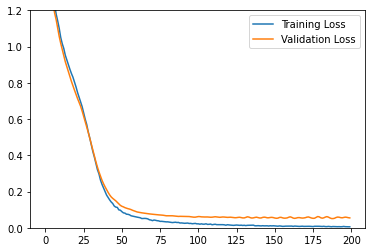

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.977
Training time,0:00:10,0:00:09,0:00:10,0:00:10,0:00:09,0:00:09,0:00:09,0:00:10,0:00:09,0:00:09
 Validation accuracy,0.992,0.992,0.992,0.993,0.990,0.992,0.992,0.992,0.992,0.992
 Prediction time,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
 Prediction accuracy,0.967,0.963,0.973,0.973,0.973,0.969,0.967,0.963,0.966,0.977,Avg = ,0.969



In [ ]:
#Training Params
BATCH_SIZE = 32
NUM_EPOCHS = 200
#kernel size is set to 1s right after DATABASE is selected
log_full_fname = start_logfiles(base_name=DATASET+'_Def_Sub',
                                first_line='Defined Subject ' + DATASET)

pass_info = "--- batch_size = " + str(BATCH_SIZE)
pass_info += " kernel_size = " + str(kernel_size)
pass_info += " num_epochs = " + str(NUM_EPOCHS) + "\n"
print (pass_info)
with open(log_full_fname, "a") as file_object:
    file_object.write(log_info)
    file_object.write(pass_info)
repeats = 10;
#for my_split in my_full_list:
for i in range(1):
    for repeat_num in range(repeats):  #rerun current config
        print("Pass number ", repeat_num + 1, " of ",repeats)
        start_time = time.time()
        history = evaluate_model(X_train, y_train, X_validation, y_validation,
                                 BATCH_SIZE, NUM_EPOCHS, my_filters = 50, 
                                 my_kernel_size = kernel_size)
        end_time = time.time()
        training_time = str(timedelta(seconds=(end_time - start_time))).split('.', 2)[0]
        print('Training time HH:MM:SS = ',training_time)
        print(method, "\nValidation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        #Plot the training and validation loss
        fig = plt.figure()
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
        plt.show()
        #Now run trained model against test set
        start_time = time.time()
        #Need to sort this out - returned arrays are re-encoded, but error
        acc = run_model(X_test, y_test)
        end_time = time.time()
        predict_time = str(timedelta(seconds = (end_time - start_time))).split('.', 2)[0]
        print('Prediction time HH:MM:SS = ',predict_time)
        print('Prediction accuracy: {0:.3f}'.format(acc[0]))
        #col_sep = '&' # for import as LaTeX table
        #end_line = '\\\\ \\hline\n' # end of table row with underline for latex
        col_sep = ',' # for csv
        end_line = '\n' # for csv
        if (repeat_num == 0):
            train_time = 'Training time'+ col_sep + training_time
            val_acc = 'Validation accuracy'+ col_sep +'%0.3f' % history.history['val_accuracy'][-1]
            pred_time = 'Prediction time' + col_sep + predict_time
            pred_acc = 'Prediction accuracy' + col_sep + '{0:.3f}'.format(acc[0])
            run_acc = acc[0] #total acc for quick avg calc
        else:
            train_time += col_sep + training_time
            val_acc += col_sep + '%0.3f' % history.history['val_accuracy'][-1]
            pred_time += col_sep + predict_time
            pred_acc += col_sep + '{0:.3f}'.format(acc[0])
            run_acc += acc[0]
    train_time += end_line
    val_acc += end_line
    pred_time += end_line
    pred_acc += col_sep + "Avg = " + col_sep + '{0:.3f}'.format(run_acc/repeats)+ end_line
    print (train_time, val_acc, pred_time, pred_acc)
    with open(log_full_fname, "a") as file_object:
            file_object.write(train_time)
            file_object.write(val_acc)
            file_object.write(pred_time)
            file_object.write(pred_acc)

#OLDER STUFF

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/UniMiB_predef_subs_Apr-04-2021_1427.txt
Processing subjects   pass  0
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 132, 50)           1050      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 113, 50)           50050     
_________________________________________________________________
dropout_8 (Dropout)          (None, 113, 50)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 56, 50)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2800)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)           

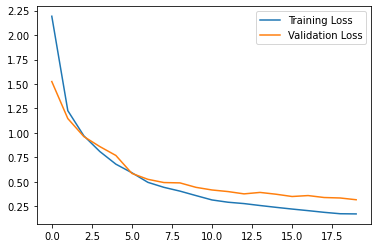

In [ ]:
#Training Params
BATCH_SIZE = 32
NUM_EPOCHS = 300
#kernel size is set to 1s right after DATABASE is selected
log_full_fname = start_logfiles(base_name=DATASET+'_Def_Sub',
                                first_line='Defined Subject ' + DATASET)

pass_info = "--- batch_size = " + str(BATCH_SIZE)
pass_info += " kernel_size = " + str(kernel_size)
pass_info += " num_epochs = " + str(NUM_EPOCHS) + "\n"
print (pass_info)
with open(log_full_fname, "a") as file_object:
    file_object.write(log_info)
    file_object.write(pass_info)

repeats = 10;
#for my_split in my_full_list:
for i in range(1):
    for repeat_num in range(repeats):  #rerun current config
        print("Processing subjects ", " pass ", repeat_num)
        # train model
        history = evaluate_model(X_train, y_train, X_validation, y_validation,
                            BATCH_SIZE, NUM_EPOCHS, my_filters = 50, 
                            my_kernel_size = kernel_size)
        # run model
        acc = run_model(X_test, y_test)
        if (repeat_num == 0):
            pred_acc = 'Prediction accuracy' + col_sep + '{0:.3f}'.format(acc[0])
            run_acc = acc[0] #total acc for quick avg calc
        else:
            output = output + '\t'+ '{0:.3f}'.format(acc)
    output = output + '\n'
    print (output)
    print(method, "\nFinal Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    with open(log_fname, "w") as file_object:
        file_object.write(log_file)
        file_object.write(output)

#Cross Validation and write results to file


In [ ]:
#Training Params
BATCH_SIZE = 32
NUM_EPOCHS = 30
#setup output file - especially important in case colab terminates
result_dir = '/content/drive/My Drive/Colab_Run_Results'
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
log_fname = '1D_CNN_'+DATASET+'_cross_val_'+timestamp
full_fname = result_dir+'/'+log_fname+'.txt'
print("Saving text log",full_fname)
with open(full_fname, "w") as file_object:
    header = "Cross validation out experiments B_Size = "+str(BATCH_SIZE)+' Epochs = ' +str(NUM_EPOCHS)+"\n"
    header = header + "Notes: Hold 6 out using split_sub method, 1 in validation\n"
    file_object.write(header)
all_unimib_sub = list(range(1,31)) #UniMIB's subjects are numbered 1-30 with no gaps
my_full_list = split_sub(all_sub = all_unimib_sub, num_hold_out = 6, num_to_validation = 1)
repeats = 5;
for my_split in my_full_list:
    for repeat_num in range(repeats):  #rerun current config
        print("Processing subjects ",str(my_split['test_subj']), " pass ", repeat_num)
        trainX, trainy, validationX, validationy, testX, testy = load_dataset(incl_val_group = True, split_subj=my_split, verbose = False)
        history = evaluate_model(trainX, trainy, validationX, validationy, BATCH_SIZE, NUM_EPOCHS)
        acc = run_model(testX, testy)
        if (repeat_num == 0):
            output = str(my_split)+'\t'+'{0:.3f}'.format(acc)
        else:
            output = output + '\t'+ '{0:.3f}'.format(acc)
    output = output + '\n'
    print (output)
    with open(full_fname, "a") as file_object:
            file_object.write(output)

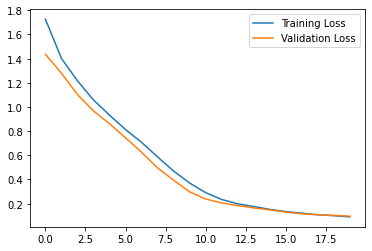

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

#Evaluate and store text based results

In [ ]:
#The output of this cell is all text so it can be captured.
#run next cell to see the results and save the txt file
#on the screen and saved in a log file using current time stamp.
%%capture --no-display results_txt
print ("Defined Subject Split")
print(get_shapes([X_train, y_train, X_validation, y_validation, X_test, y_test]))
print("Batch size =",BATCH_SIZE,"Number Epochs =",NUM_EPOCHS)
#print (model.summary())
#print('Training time   =',(np.str(train_time).split(".")[0]), 'HH:MM:SS')
#print('Evaluation time =',(np.str(eval_time).split(".")[0]), 'HH:MM:SS')
print("Using CPU only")#,gpu_info[1])
print(classification_report(y_test, y_pred, target_names=ACT))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

NameError: ignored

In [ ]:
#display stored output of previous cell (need linux tee function...)
print(results_txt)

1D CNN with UniMiB SHAR
trainX shape (6479, 151, 1) trainY shape (6479, 9)
validationX shape (739, 151, 1) validationy shape (739, 9)
testX shape (361, 151, 1) testy shape (361, 9)
Batch size = 32 Number Epochs = 20
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 142, 100)          1100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 133, 100)          100100    
_________________________________________________________________
dropout (Dropout)            (None, 133, 100)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 66, 100)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6600)              0         
______________________________________

In [ ]:
#build log filename and store results
result_dir = '/content/drive/My Drive/Colab_Run_Results'
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
acc_str = '{:.0f}'.format(accuracy_score(y_test, y_pred)*100)
log_fname = '1D_CNN_'+DATASET+'_'+acc_str+'_'+timestamp
full_fname = result_dir+'/'+log_fname+'.txt'
print("Saving text log",full_fname)
with open(full_fname, "w") as text_file:
    print(results_txt, file=text_file)
pred_fname = result_dir+'/'+log_fname+'.csv'  
#convert to pandas for labeling columns in csv
print("Saving test and predictions as ",pred_fname)
df_predictions = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_predictions.to_csv(pred_fname)

Saving text log /content/drive/My Drive/Colab_Run_Results/1D_CNN_UniMiB_SHAR_92_Jul-10-2020_0252.txt
Saving test and predictions as  /content/drive/My Drive/Colab_Run_Results/1D_CNN_UniMiB_SHAR_92_Jul-10-2020_0252.csv


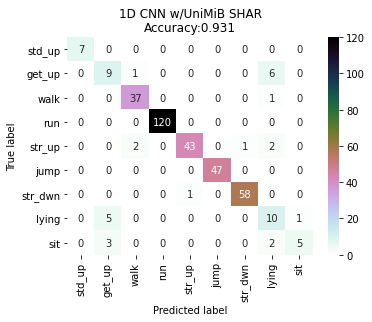

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ACT, 
                     columns = ACT)
fig = plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN w/'+DATASET+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#save the figure - makes both png and pdf versions
full_fname = result_dir+'/'+log_fname+'.png'
print("saving cm plot as",full_fname)
fig.savefig(full_fname)
full_fname = result_dir+'/'+log_fname+'.pdf'
print("saving cm plot as",full_fname)
fig.savefig(full_fname,format='pdf')

saving cm plot as /content/drive/My Drive/Colab_Run_Results/1D_CNN_UniMiB_SHAR_92_Jul-10-2020_0252.png
saving cm plot as /content/drive/My Drive/Colab_Run_Results/1D_CNN_UniMiB_SHAR_92_Jul-10-2020_0252.pdf
